## Load Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from Cython.Compiler.Naming import args_cname
from tensorboard.compat.tensorflow_stub.dtypes import float32
from torch.utils.data import DataLoader, TensorDataset
from typing import Tuple, Dict, Any, Optional
from dataclasses import dataclass
import tqdm
import matplotlib.pyplot as plt
from torchvision.models import resnet34
import torch.optim as optim
import os
from torch.optim.lr_scheduler import MultiStepLR
import gc

In [3]:
os.chdir('/content/drive/MyDrive')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data loading

In [5]:
def load_dataset(file_path, val_ratio=0.2, random_state=42):
    dataset = np.load(file_path)
    Xtr, Str = dataset['Xtr'], dataset['Str']
    Xts, Yts = dataset['Xts'], dataset['Yts']

    # Shuffle & split (80% train, 20% validation)
    np.random.seed(random_state)
    indices = np.arange(len(Str))
    np.random.shuffle(indices)

    split_idx = int(len(Str) * (1 - val_ratio))
    train_idx, val_idx = indices[:split_idx], indices[split_idx:]

    X_train, y_train = Xtr[train_idx], Str[train_idx]
    X_val, y_val = Xtr[val_idx], Str[val_idx]

    return X_train, y_train, X_val, y_val, Xts, Yts

def reshape_mnist(*arrays):
    reshaped = []

    for arr in arrays:
        if arr.ndim == 1:
            arr = torch.tensor(arr, dtype=torch.long)
        elif arr.ndim >= 2:
            arr = arr.reshape(-1, 1, 28, 28)
            arr = torch.tensor(arr, dtype=torch.float32) / 255.0
            mean = torch.tensor(0.1307, dtype=torch.float32).view(1, 1, 1)
            std  = torch.tensor(0.3081, dtype=torch.float32).view(1, 1, 1)
            arr = (arr - mean) / std
        reshaped.append(arr)
    return tuple(reshaped)

def reshape_cifar(*arrays):
    reshaped = []
    mean = torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32).view(3, 1, 1)
    std  = torch.tensor([0.2023, 0.1994, 0.2010], dtype=torch.float32).view(3, 1, 1)
    for arr in arrays:
        if arr.ndim == 1:
            arr = torch.tensor(arr, dtype=torch.long)
        elif arr.ndim >= 2:
            arr = np.transpose(arr, (0, 3, 1, 2))
            arr = torch.tensor(arr, dtype=torch.float32) / 255.0
            arr = (arr - mean) / std
        reshaped.append(arr)
    return tuple(reshaped)


## Dataset testing

In [ ]:
Xtr_03, Str_03, Xval_03, Sval_03, Xts_03, Yts_03 = reshape_mnist(*load_dataset('datasets/FashionMNIST0.3.npz'))
Xtr_06, Str_06, Xval_06, Sval_06, Xts_06, Yts_06 = reshape_mnist(*load_dataset('datasets/FashionMNIST0.6.npz'))
Xtr_cifar, Str_cifar, Xval_cifar, Sval_cifar, Xts_cifar, Yts_cifar = reshape_cifar(*load_dataset('datasets/CIFAR.npz'))

In [ ]:
print("Xtr_03:", Xtr_03.shape)
print("Xtr_06:", Xtr_06.shape)
print("Xtr_cifar:", Xtr_cifar.shape)

Xtr_03: torch.Size([14400, 1, 28, 28])
Xtr_06: torch.Size([14400, 1, 28, 28])
Xtr_cifar: torch.Size([12000, 3, 32, 32])


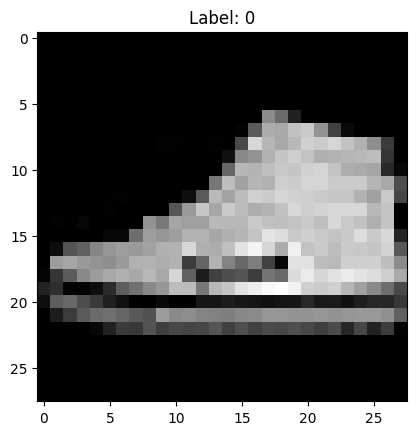

In [ ]:
# Mnist data checking
plt.imshow(Xtr_03[114, -1, :, :], cmap='gray') #[pic number,_,_,_]
plt.title(f"Label: {Str_03[0]}")
plt.show()

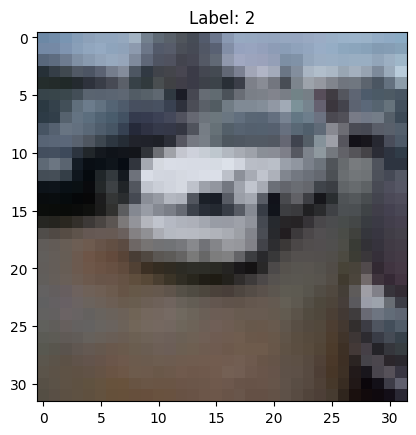

In [ ]:
# CIFAR data checking
mean_test = torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32).view(3, 1, 1)
std_test  = torch.tensor([0.2023, 0.1994, 0.2010], dtype=torch.float32).view(3, 1, 1)
test_cifar = Xtr_cifar[514] * std_test + mean_test
plt.imshow(np.transpose(test_cifar, (1, -1, 0)))
plt.title(f"Label: {Str_cifar[0]}")
plt.show()

## True transition matrix reloading

In [6]:
class FixedTransition(nn.Module):

    def __init__(self, T: torch.Tensor):
        super().__init__()

        T = T.detach().float()
        self.register_buffer("T", T)

    def forward(self):
        return self.T
def select_known_T(dataset_name: str):

    mnist03_T = torch.tensor([
        [0.7, 0.3, 0.0],
        [0.0, 0.7, 0.3],
        [0.3, 0.0, 0.7]
    ], dtype=torch.float32, device=device)

    mnist06_T = torch.tensor([
        [0.4, 0.3, 0.3],
        [0.3, 0.4, 0.3],
        [0.3, 0.3, 0.4]
    ], dtype=torch.float32, device=device)

    name = dataset_name.lower()
    if "3" in name or "mnist03" in name:
        return FixedTransition(mnist03_T)
    if "6" in name or "mnist06" in name:
        return FixedTransition(mnist06_T)
    return None

# Main Program

## Classifier: ResNet-tiny

In [40]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes,mode='cifar'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        if mode == 'cifar':
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0, bias=False)
        else:
            self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        #self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        #self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(128*block.expansion, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, revision=True):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        #out = self.layer3(out)
        #out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)

        out = self.linear(out)

        clean = F.softmax(out, 1)

        return clean

def ResNet_tiny(num_classes,mode):
  return ResNet(BasicBlock, [1,1], num_classes,mode)

## Transition matrix initialization

In [8]:

class sig_t(nn.Module):
    def __init__(self, device, num_classes, init=2):
        super(sig_t, self).__init__()

        C = num_classes
        self.register_parameter(name='w', param=nn.parameter.Parameter(-init*torch.ones(num_classes, num_classes)))

        co = torch.full((C, C), 0.3, device=device)
        co.fill_diagonal_(0.4)
        self.register_buffer("co", co)
        self.register_buffer("I", torch.eye(C))



    def forward(self):
        sig = torch.sigmoid(self.w)

        T = self.I + sig * self.co
        return T


def row_stoch(M, eps=1e-8):
    M = M.clamp_min(Cfg.eps)
    return M / (M.sum(dim=1, keepdim=True) + Cfg.eps)


## Main structrue

In [36]:
def warmup(train_data, train_loader, model,optimizer_model, loss_func_ce):

    model.train()
    train_loss = 0.

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer_model.zero_grad()

        clean = model(batch_x)

        ce_loss = loss_func_ce(clean.log(), batch_y.long())
        loss = ce_loss

        train_loss += loss.item()

        loss.backward()
        optimizer_model.step()


    print('Warmup Loss: {:.6f}'.format(train_loss / (len(train_data))*Cfg.batch_size))


def train(train_data, train_loader,model,trans_for,trans_back,optimizer_es,optimizer_trans_for,optimizer_trans_back,scheduler1,scheduler2,scheduler3,loss_func_ce):
    model.train()
    trans_back.train()
    trans_for.train()

    if optimizer_trans_for is None:
        trans_for.eval()
    else:
        trans_for.train()


    loss_sum = 0.0
    acc_sum  = 0
    n_samp   = 0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y_idx = batch_y.to(device).long()

        clean = model(batch_x)
        noisy_1h = torch.zeros(batch_x.size(0), Cfg.num_classes, device=device).scatter_(1, batch_y_idx.view(-1,1), 1)

        # ------- L1: forward-------
        T_for = trans_for()
        T_back = trans_back()

        T_for  = row_stoch(T_for)
        T_back = row_stoch(T_back)

        p_noisy_pred = (clean @ T_for).clamp_min(Cfg.eps)
        L1 = loss_func_ce(p_noisy_pred.log(), batch_y_idx)

        # ------- L2: backward-------
        p_clean_from_noisy = (noisy_1h @ T_back).clamp_min(Cfg.eps)
        L2 = -(p_clean_from_noisy * clean.clamp_min(Cfg.eps).log()).sum(dim=1).mean()

        # ------- L3: cycle-consistency -------
        T_for_det  = T_for.detach()
        T_back_det = T_back.detach()
        p_cycle = ((clean @ T_for_det).clamp_min(Cfg.eps) @ T_back_det).clamp_min(Cfg.eps)
        L3 = -(clean * p_cycle.log()).sum(dim=1).mean()

        # ------- L4: reverse correction -------
        I = torch.eye(Cfg.num_classes, device=device)
        R_inv = (row_stoch(T_back) @ row_stoch(T_for).detach() - I).abs().mean()

        loss = L1 + L2 + Cfg.w_cycle * L3 + Cfg.r_inv * R_inv

        pred_noisy = p_noisy_pred.argmax(dim=1)
        acc_sum += (pred_noisy == batch_y_idx).sum().item()


        optimizer_es.zero_grad()
        if optimizer_trans_for is not None:
            optimizer_trans_for.zero_grad()
        optimizer_trans_back.zero_grad()

        loss.backward()

        optimizer_es.step()
        if optimizer_trans_for is not None:
            optimizer_trans_for.step()
        optimizer_trans_back.step()

        bs = batch_x.size(0)
        loss_sum += loss.item() * bs
        n_samp += bs

    print('Train Loss: {:.6f},  Acc: {:.6f}'.format(loss_sum / max(1, n_samp), acc_sum / max(1, n_samp)))  # [FIX]

    scheduler1.step()
    if scheduler2 is not None:
        scheduler2.step()
    scheduler3.step()


def val(val_data, val_loader, model, trans, loss_func_ce):
    val_correct = 0
    val_loss_sum = 0.0
    total_n = 0
    with torch.no_grad():
        model.eval()
        trans.eval()

        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            clean = model(batch_x)
            T_back = trans()
            T_back = row_stoch(T_back)
            #T_back = T_back / (T_back.sum(dim=0, keepdim=True) + 1e-8)

            noisy_1h = torch.zeros(batch_x.size(0), Cfg.num_classes, device=device).scatter_(1, batch_y.view(-1,1), 1)


            est_clean = torch.mm(noisy_1h, T_back).clamp_min(1e-8)
            est_clean_y = est_clean.argmax(dim=1)


            loss = -(est_clean * clean.clamp_min(1e-8).log()).sum(dim=1).mean()

            pred_clean = clean.argmax(dim=1)
            est_clean_y = est_clean.argmax(dim=1)
            bs = batch_x.size(0)
            val_correct += (pred_clean == est_clean_y).sum().item()
            val_loss_sum += loss.item() * bs
            total_n += bs

    avg_val_loss = val_loss_sum / max(1, total_n)
    avg_val_acc  = val_correct / max(1, total_n)
    print('Val Loss: {:.6f}, Acc: {:.6f}'.format(avg_val_loss, avg_val_acc))
    return avg_val_loss


def test(test_data, test_loader, model, loss_func_ce):
    eval_loss = 0.
    eval_acc = 0.

    with torch.no_grad():
        model.eval()

        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            clean = model(batch_x)

            loss = loss_func_ce(clean.clamp_min(1e-8).log(), batch_y.long())
            eval_loss += loss.item()
            pred = torch.max(clean, 1)[1]
            eval_correct = (pred == batch_y).sum()
            eval_acc += eval_correct.item()

        print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(test_data)) * Cfg.batch_size,
                                                      eval_acc / (len(test_data))))
    return eval_acc / (len(test_data))


## Operation process

In [56]:
def main(dataset_name):

      try:
          del model
      except:
          pass
      try:
          del trans; del trans_1
      except:
          pass
      gc.collect()
      if torch.cuda.is_available():
        torch.cuda.empty_cache()

      best_Tf_np = None
      best_Tb_np = None
      best_epoch_tag = None



      #init
      criterion = torch.nn.NLLLoss(reduction="mean")
      model = ResNet_tiny(Cfg.num_classes, dataset_name)
      milestones = Cfg.milestones

      if dataset_name.lower() in ("mnist03"):
          Xtr, ytr, Xva, yva, Xte, yte = reshape_mnist(*load_dataset("datasets/FashionMNIST0.3.npz"))
      elif dataset_name.lower() in ("mnist06"):
          Xtr, ytr, Xva, yva, Xte, yte = reshape_mnist(*load_dataset("datasets/FashionMNIST0.6.npz"))
      elif dataset_name.lower() in ("cifar"):
          Xtr, ytr, Xva, yva, Xte, yte = reshape_cifar(*load_dataset("datasets/CIFAR.npz"))
      else:
          raise ValueError(f"Unsupported dataset: {dataset_name}")

      train_data = TensorDataset(Xtr, ytr)
      val_data = TensorDataset(Xva, yva)
      test_data = TensorDataset(Xte, yte)

      trans_known = select_known_T(dataset_name) if Cfg.use_true_T_forward else None
      has_clean_T = trans_known is not None

      if has_clean_T:
          print(f"[Info] Using provided true transition matrix for {dataset_name}")
          trans = trans_known
          optimizer_trans = None
          scheduler2 = None
      else:
          trans = sig_t(device, Cfg.num_classes)
          optimizer_trans = optim.AdamW(trans.parameters(), lr=Cfg.lr, weight_decay=0)
          scheduler2 = MultiStepLR(optimizer_trans, milestones=milestones, gamma=0.1)


      trans_1 = sig_t(device, Cfg.num_classes)
      optimizer_trans_1 = optim.AdamW(trans_1.parameters(), lr=Cfg.lr, weight_decay=0)


      #optimizer and StepLR
      optimizer_es = optim.AdamW(model.parameters(), lr=Cfg.lr, weight_decay=Cfg.weight_decay)
      scheduler1 = MultiStepLR(optimizer_es, milestones=milestones, gamma=0.1)
      scheduler3 = MultiStepLR(optimizer_trans_1, milestones=milestones, gamma=0.1)


      #data_loader
      train_loader = DataLoader(dataset=train_data,
                                batch_size=Cfg.batch_size,
                                shuffle=True,
                                num_workers=4,
                                drop_last=False)

      val_loader = DataLoader(dataset=val_data,
                              batch_size=Cfg.batch_size,
                              shuffle=False,
                              num_workers=4,
                              drop_last=False)

      test_loader = DataLoader(dataset=test_data,
                              batch_size=Cfg.batch_size,
                              num_workers=4,
                              drop_last=False)

      #cuda
      if torch.cuda.is_available():
          model = model.to(device)
          trans = trans.to(device)
          trans_1 = trans_1.to(device)


      best_acc = 0
      best_warm_up_acc = 0
      best_acc_back = 0
      #warmup
      for epoch in range(Cfg.warmup_epoch):
          print('epoch[{}], Warmup'.format(epoch + 1))
          warmup(train_data, train_loader, model,optimizer_es, criterion)
          val(val_data, val_loader, model, trans_1, criterion)
          acc = test(test_data, test_loader, model,criterion)
          if acc> best_warm_up_acc:
              best_warm_up_acc = acc
          print('Best_acc: {:.6f}'.format(best_warm_up_acc))

      acc_list = []
      loss_list = []
      early_stop = 0
      best_val_loss = float('inf')
      best_Tf_np, best_Tb_np, best_epoch_tag = None, None, None

      #train
      for epoch in range(Cfg.n_epoch):
          print('epoch[{}], Train'.format(epoch+1))
          train(train_data,train_loader,model,trans,trans_1,optimizer_es,optimizer_trans,optimizer_trans_1,scheduler1,scheduler2,scheduler3,criterion)
          val_loss = val(val_data, val_loader, model, trans_1,criterion)
          acc = test(test_data, test_loader, model,criterion)

          acc_list.append(acc)
          loss_list.append(val_loss)

          improved = val_loss < best_val_loss - 1e-6
          best_acc = max(best_acc, acc)

          if improved:
            best_val_loss = val_loss
            best_epoch_tag = epoch + 1
            with torch.no_grad():
              Tf_use = row_stoch(trans().detach().float().cpu()).numpy()
              Tb_use = row_stoch(trans_1().detach().float().cpu()).numpy()
              best_Tf_np, best_Tb_np = Tf_use, Tb_use
            early_stop = 0
            print('Best_acc: {:.6f}'.format(best_acc))
          else:
            early_stop += 1
            print('Best_acc: {:.6f}'.format(best_acc))
            if early_stop >= Cfg.es_epoch:
              print(f"⏹ Early stopping at epoch {epoch+1} (best val_loss={best_val_loss:.6f}, best acc={best_acc:.6f})")
              break

      if best_Tf_np is not None:
        Tf_np, Tb_np = best_Tf_np, best_Tb_np
      else:
        with torch.no_grad():
          Tf_np = row_stoch(trans().detach().float().cpu()).numpy()
          Tb_np = row_stoch(trans_1().detach().float().cpu()).numpy()

      print('Best_acc: ', best_acc)

      return best_acc,acc_list,loss_list,Tf_np, Tb_np


# Running

In [69]:
# ---------------------------
# Config
# ---------------------------
@dataclass
class Cfg:
    num_classes: int = 3
    dataset: str = "cifar"
    batch_size: int = 128
    n_epoch: int = 120
    warmup_epoch: int = 5
    es_epoch: int = 30
    eps: float = 1e-8
    lr: float = 0.005
    weight_decay: float = 1e-5
    milestones: Tuple[int, int] = (20, 40)
    w_cycle: float = 0.2
    use_true_T_forward: bool = True
    r_inv: float = 0
    anchor: bool = False
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


In [70]:
best,acc_list,loss_list ,Tf, Tb = main(Cfg.dataset)

epoch[1], Warmup
Warmup Loss: 1.123843
Val Loss: 1.103123, Acc: 0.379333
Test Loss: 1.049199, Acc: 0.532000
Best_acc: 0.532000
epoch[2], Warmup
Warmup Loss: 1.101524
Val Loss: 1.095972, Acc: 0.381333
Test Loss: 1.074546, Acc: 0.587667
Best_acc: 0.587667
epoch[3], Warmup
Warmup Loss: 1.097931
Val Loss: 1.092880, Acc: 0.376333
Test Loss: 1.038867, Acc: 0.667667
Best_acc: 0.667667
epoch[4], Warmup
Warmup Loss: 1.097846
Val Loss: 1.097330, Acc: 0.366667
Test Loss: 1.065062, Acc: 0.512667
Best_acc: 0.667667
epoch[5], Warmup
Warmup Loss: 1.096002
Val Loss: 1.095724, Acc: 0.369000
Test Loss: 1.084811, Acc: 0.487000
Best_acc: 0.667667
epoch[1], Train
Train Loss: 2.407275,  Acc: 0.367167
Val Loss: 1.093935, Acc: 0.378333
Test Loss: 1.058690, Acc: 0.577333
Best_acc: 0.577333
epoch[2], Train
Train Loss: 2.405458,  Acc: 0.376083
Val Loss: 1.093230, Acc: 0.372000
Test Loss: 1.055883, Acc: 0.584000
Best_acc: 0.584000
epoch[3], Train
Train Loss: 2.405429,  Acc: 0.372333
Val Loss: 1.090156, Acc: 0.382

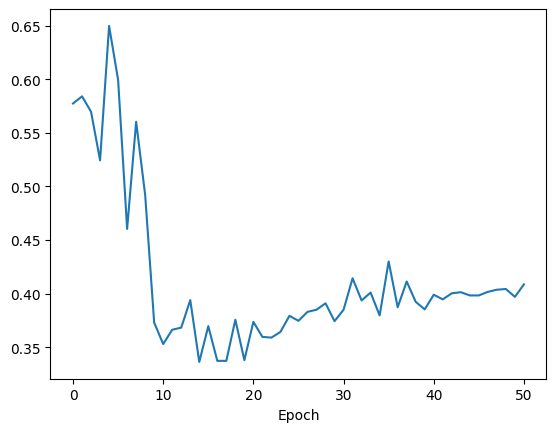

In [71]:
x_label = list(range(len(loss_list)))
plt.plot(x_label, acc_list)
plt.xlabel("Epoch")
plt.show()

In [72]:
print("\n=== Forward T (row-stoch) ===")
print(np.array_str(Tf, precision=3, suppress_small=True, max_line_width=180))
print("row sums:", np.round(Tf.sum(axis=1), 6))

print("\n=== Backward T (row-stoch) ===")
print(np.array_str(Tb, precision=3, suppress_small=True, max_line_width=180))
print("row sums:", np.round(Tb.sum(axis=1), 6))



=== Forward T (row-stoch) ===
[[0.984 0.01  0.006]
 [0.126 0.866 0.008]
 [0.181 0.116 0.703]]
row sums: [1. 1. 1.]

=== Backward T (row-stoch) ===
[[0.63  0.184 0.187]
 [0.    0.773 0.227]
 [0.    0.001 0.999]]
row sums: [1. 1. 1.]
